In [18]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.fft import fft2, ifft2, rfft2, irfft2
import time
from time import strftime, gmtime
import numba
from numba import jit
import pandas as pd
import sys

import concurrent.futures
import multiprocessing
num_processes = multiprocessing.cpu_count()

from timeit import default_timer as timer

import sympy

font = {'family': 'serif',
          'color':  'black',
          'weight': 'normal',
          'size': 16,
          }

In [30]:
global first_term, second_term, third_term, V_ph, V_ph_k, rho, dt, U, dl

N = 512
L = 80

#del r_discretization, k_discretization
dl = L / N
l = np.linspace(-L/2,L/2,N)
X, Y = np.meshgrid(l,l)

mu2_p = np.zeros((N,N))
lambda2_q = np.zeros((N,N))

for i in range(0,N):
  for j in range(0,N//2):
    mu2_p[i,j] = pow(j * 2 * np.pi / L, 2)
  for j in range(N//2,N):    
    mu2_p[i,j] = pow((j - N) * 2 * np.pi / L, 2)

for j in range(0,N):     
  for i in range(0,N//2):    
    lambda2_q[i,j] = pow(i * 2.0 * np.pi / L, 2);    
  for i in range(N//2,N):    
    lambda2_q[i,j] = pow((i - N) * 2.0 * np.pi / L, 2)
    
K2 = mu2_p+lambda2_q
K = np.sqrt(K2)

g = np.ones((N,N), dtype=np.float32)
S = np.ones((N,N), dtype=np.float32)

#Initializing the terms
first_term = np.zeros((N,N), dtype=np.complex64)
second_term = np.zeros((N,N), dtype=np.complex64)
third_term = np.zeros((N,N), dtype=np.complex64)

V_ph = np.zeros((N,N), dtype=np.complex64) 
V_ph_k = np.zeros((N,N), dtype=np.complex64)

In [31]:
@numba.jit(nopython=True, parallel=False)
def primeira_derivada( dr, y_anterior, y_0):
  derivada = (y_0-y_anterior)/dr
  return derivada

@numba.jit(nopython=True, parallel=True)
def calculate_second_term(g):
  #Calculating the second gradient of |sqrt(g(r))|^2
  grad_x = np.zeros((N,N), dtype=np.complex64)
  grad_y = np.zeros((N,N), dtype=np.complex64)

  for i in range(0,N):
    for j in range(0,N-1):
        grad_x[i,j] = g[i,j] - g[i,j+1]
    grad_x[i,N-1] = grad_x[i,N-2] 

  for j in range(0,N):
    for i in range(0,N-1):
        grad_y[i,j] = g[i,j] - g[i+1,j]
    grad_y[N-1,j] = grad_y[N-2,j]  

  aux = (grad_x*grad_x+grad_y*grad_y) / (dl * dl)
  gradient_root_g = aux / (4.0*np.absolute(g))

  return gradient_root_g

In [32]:
U = 10
rho = 1

v = U*np.exp(-X*X-Y*Y)
c1 = pow(2*np.pi,-2) / rho

g = np.ones((N,N), dtype=np.float32)
S = np.ones((N,N), dtype=np.float32)
aux = np.zeros((N,N))
dt = 0.001
condition = True
counter = 1
while condition:
  omega_k = -0.5*K2*(2*S+1)*(1-(1/S))*(1-(1/S))
  omega = np.real(ifft2(omega_k) * c1) 
  gradient_g = calculate_second_term(g)
  V_ph = g*v+2*gradient_g+(g-1)*omega
  V_ph_k = rho * fft2(V_ph)
  aux = np.real(K2+2*V_ph_k)
  #if any(np.less_equal(aux, 0)):
   # print("instability at rho = ", rho)
    #break
  new_S = K / np.sqrt(np.abs(aux))
  S = (1-dt)*S + dt*new_S
  new_g = np.real(1+fft2(S-1) * c1) 
  if counter%100==0 or counter==1:
    error = np.sum(np.sum(g-new_g)) * dl * dl
    condition = error > 1e-6
    print('i = {}, error = {}'.format(counter, error))
    
  g = new_g
  
  counter = counter + 1

i = 1, error = 0.16211180667567246
i = 100, error = 0.14682620616987413
i = 200, error = 0.1328471983329888
i = 300, error = 0.12019910181775476
i = 400, error = 0.10875520341482509
i = 500, error = 0.09840085400744991
i = 600, error = 0.08903231997524125
i = 700, error = 0.08055574395293752
i = 800, error = 0.07288620453350325
i = 900, error = 0.06594686549484365


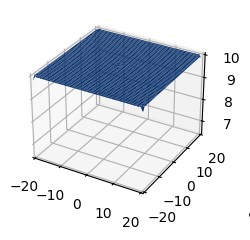

In [ ]:
v = U*np.exp(-X*X-Y*Y)

from matplotlib import cm

plt.style.use('_mpl-gallery')
Z = g
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, vmin=Z.min(), cmap=cm.Blues)

#ax.set(xticklabels=[], yticklabels=[], zticklabels=[])

ax.set_xlim([l.min(),l.max()])
ax.set_zlim([Z.min(),Z.max()])
ax.set_ylim([l.min(),l.max()])

plt.show()

In [16]:
N = 10
g = np.ones((N,N), dtype=np.float32)
a = fft2(g)
b = ifft2(a)
b-g

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j]], dtype=complex64)